# Twitter Fake News Detection
Hayden Hoopes

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. In this competition, I am challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. I'll be using a dataset of 10,000 tweets that were hand classified.

## Dataset information
The data that I am using comes from a Kaggle competition called "Natural Language Processing with Disaster Tweets". This data set has 7,613 tweets (in the training set), many of which contain hashtags which I have not yet decided how to handle. However, I think that I may try to keep the hashtags with the pound symbol so that they can be distinguished from regular words. In a future analysis, I might change this.

The purpose of the Kaggle competition is to be able to determine which tweets are about real disasters and which ones just use weather-related language. Thus, it's a classification problem.

In terms of natural language processing, I would like to engage in text normalization, feature engineering, text classification, word clustering, and word embeddings in this analysis.

## Import packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train.shape

(7613, 5)

In [3]:
test.shape

(3263, 4)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Data Summary
In this data summary, I can see that in the training data, 57% of tweets are classified as class `0`, which likely means that they were not about real disasters. That gives me a threshold to beat of 57% in terms of the accuracy of my model, which is the accuracy that I would get if I just guessed all tweets as class `0`.

In [6]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

It also looks like there is quite a bit of null data in the training data, mostly in the `location` column. I'll probably combine both the `keyword` and `location` values into the `text` column and then drop them both so that I am left with a single column that has all of the words.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
np.where(train['keyword'].isna(), '', train['keyword'])

array(['', '', '', ..., '', '', ''], dtype=object)

In [9]:
# Convert null values to empty strings
train['keyword'] = np.where(train['keyword'].isna(), '', train['keyword'])
train['location'] = np.where(train['location'].isna(), '', train['location'])

# Concatenate all text together
train['text'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']

In [10]:
# Drop keyword and location columns. Might as well drop the id column here as well
train = train.drop(['keyword', 'location', 'id'], axis=1)

In [11]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' ar...,1
3,"13,000 people receive #wildfires evacuation ...",1
4,Just got sent this photo from Ruby #Alaska a...,1


## Preprocess text
In this step, I plan to perform several steps to preprocess the text and get it ready to be analyzed. The steps include the following:
- Convert all letters to lowercase
- Remove punctuation and strip the text of newline characters and extra spaces
- Remove numbers
- Remove stop words

I was going to remove the hashtags from the text as well but then I discoverd the `TweetTokenizer` from `nltk`. It keeps the hashtags and creates tokens with them so I am interested to see how it works.

### Tokenize the text

In [12]:
# The Tweet Tokenizer is specially built for tweets
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

train['tokens'] = train['text'].apply(tt.tokenize)

### Remove stop words, symbols, letters, and extra spaces. Lemmatize the words as well

In [13]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# The lemmatizer will convert words to their root forms
lemmatizer = WordNetLemmatizer()

# The stop words will allow me to get rid of filler words
stop_words = set(stopwords.words('english'))

# This is a simple function for cleaning the text
def clean_text(tokens):
    clean_tokens = []
    for token in tokens:
        clean_token = token.strip().lower()
        clean_token = re.sub('([^a-zA-Z#]+)', '', clean_token)
        if clean_token in stop_words or len(clean_token) <= 2: # clean_token == '' : Decided to remove all words less than 2 characters
            pass
        else:
            clean_token = lemmatizer.lemmatize(clean_token)
            clean_tokens.append(clean_token)
            
    return clean_tokens

In [14]:
train['clean_tokens'] = train['tokens'].apply(clean_text)

### Rejoin the tokens into text

In [15]:
train['text'] = train['clean_tokens'].apply(lambda tokens : ' '.join(tokens))

### Drop unnecessary columns

In [16]:
train = train.drop(['tokens', 'clean_tokens'], axis=1)

## Feature Engineering
In this step, I will use the TF-IDF Vectorizer to sparse out the text data into a format that can be used to build a classifier. After running the classifier, I get a dataframe with 21,293 columns. Let's see how well it works.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(min_df=0., max_df=1., ngram_range=(1,1))

# X is now my features, one row for each document and one column for each word
X = tv.fit_transform(train['text']).toarray()
y = train['target']

In [18]:
X.shape

(7613, 21293)

## First model
For my first model, I am going to perform 10 fold cross-validation on this data set to see how good of an accuracy I can get with a basic Naive Bayes classifier.

After performing 10-fold cross validation on the training data using the Gaussian Naive Bayes classifier, I can be confident that my classifier can classify if a tweet is about a real natural disaster or not with an accuracy of about 60%. This is barely better than the baseline accuracy threshold, which was 57%. I think that this could be improved in the future.

In [19]:
from sklearn.naive_bayes import GaussianNB

folds = np.random.randint(1, 11, X.shape[0])

accuracies = []

for fold in range(1, 11):
    cv_train = X[folds != fold]
    cv_validate = X[folds == fold]
    y_train = y[folds != fold]
    y_validate = y[folds == fold]
    
    nb = GaussianNB()
    nb.fit(cv_train, y_train)
    predicted = nb.predict(cv_validate)
    
    accuracy = (predicted == y_validate).sum() / len(predicted)
    accuracies.append(accuracy)   

In [20]:
# Average accuracy of classifier
sum(accuracies) / len(accuracies)

0.6061452936370588

## Second model - Random Forest
I tried using a Random Forest classifier in a second model and got a much higher cross-validation accuracy of 76%, which is much higher than the base threshold of 57%.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

tv = TfidfVectorizer(min_df=0.005, max_df=1., ngram_range=(1,1))

X = tv.fit_transform(train['text']).toarray()

print(X.shape)

y = train['target']

folds = np.random.randint(1, 11, X.shape[0])

accuracies = []

for fold in range(1, 11):
    cv_train = X[folds != fold]
    cv_validate = X[folds == fold]
    y_train = y[folds != fold]
    y_validate = y[folds == fold]
    
    rf = RandomForestClassifier()
    rf.fit(cv_train, y_train)
    predicted = rf.predict(cv_validate)
    
    accuracy = (predicted == y_validate).sum() / len(predicted)
    accuracies.append(accuracy)
    print(f'Fold {fold} accuracy: {accuracy}')

(7613, 342)
Fold 1 accuracy: 0.7667934093789607
Fold 2 accuracy: 0.752895752895753
Fold 3 accuracy: 0.7774798927613941
Fold 4 accuracy: 0.7523680649526387
Fold 5 accuracy: 0.764404609475032
Fold 6 accuracy: 0.7462482946793997
Fold 7 accuracy: 0.7583444592790387
Fold 8 accuracy: 0.7565337001375516
Fold 9 accuracy: 0.759526938239159
Fold 10 accuracy: 0.7595561035758323


In [22]:
# Average accuracy of classifier
sum(accuracies) / len(accuracies)

0.7594151225374761

In [23]:
from sklearn.metrics import classification_report
print(classification_report(predicted, y_validate))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       483
           1       0.69      0.74      0.71       328

    accuracy                           0.76       811
   macro avg       0.75      0.76      0.75       811
weighted avg       0.76      0.76      0.76       811



Next steps:

What are the most influential words in determining if a tweet is fake news or not?
Can I use cosine distance to improve the score of the model, rather than TF-IDF weights?


In [24]:
# Use cosine similarity instead of TF-IDF
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(X)

In [25]:
# Perform a PCA analysis to see if distinct clusters are forming (out of curiousity)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

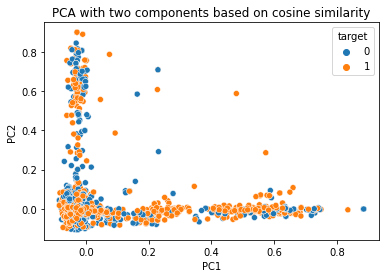

In [26]:
dims = pca.fit_transform(X, y)
df_pca = pd.DataFrame(dims, columns=['PC1', 'PC2'])
df_pca = pd.concat([df_pca, y], axis=1)

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target')
plt.title('PCA with two components based on cosine similarity')
plt.show()

In [27]:
# Determine the optimal number of PCA components
# If just a few components can achieve a high accuracy, I might be able to continue with just a few components to make my code run faster
pca_accuracies = []

for n_components in range(1, 20):    
    print(f"Starting random forest for PCA n_component={n_components}")
    folds = np.random.randint(1, 11, X.shape[0])
    accuracies = []
    for fold in range(1, 11):
        pca = PCA(n_components=n_components)
        
        cv_train = X[folds != fold]
        cv_validate = X[folds == fold]
        y_train = y[folds != fold]
        y_validate = y[folds == fold]
        
        pca.fit(cv_train)
        cv_train = pca.transform(cv_train)
        cv_validate = pca.transform(cv_validate)
        

        rf = RandomForestClassifier()
        rf.fit(cv_train, y_train)
        predicted = rf.predict(cv_validate)

        accuracy = (predicted == y_validate).sum() / len(predicted)
        accuracies.append(accuracy)
        # print(f'Fold {fold} accuracy: {accuracy}')
    pca_accuracies.append(sum(accuracies)/len(accuracies))
    print(f'Average accuracy for PCA={n_components}: {sum(accuracies)/len(accuracies)}')

Starting random forest for PCA n_component=1
Average accuracy for PCA=1: 0.6193740356938002
Starting random forest for PCA n_component=2
Average accuracy for PCA=2: 0.6542546476078442
Starting random forest for PCA n_component=3
Average accuracy for PCA=3: 0.681633860700288
Starting random forest for PCA n_component=4
Average accuracy for PCA=4: 0.6905679302405188
Starting random forest for PCA n_component=5
Average accuracy for PCA=5: 0.7076250359086227
Starting random forest for PCA n_component=6
Average accuracy for PCA=6: 0.7167768572909914
Starting random forest for PCA n_component=7
Average accuracy for PCA=7: 0.7198767711056947
Starting random forest for PCA n_component=8
Average accuracy for PCA=8: 0.7227766165789677
Starting random forest for PCA n_component=9
Average accuracy for PCA=9: 0.7293336047603822
Starting random forest for PCA n_component=10
Average accuracy for PCA=10: 0.7276185846122687
Starting random forest for PCA n_component=11
Average accuracy for PCA=11: 0.73

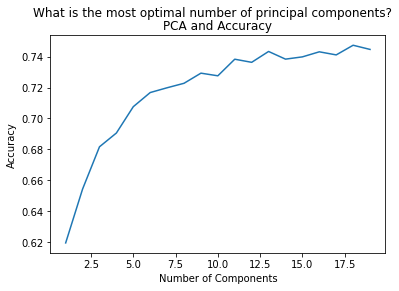

In [28]:
plt.plot([i for i in range(1, 20)], pca_accuracies)
plt.title('PCA and Accuracy')
plt.suptitle('What is the most optimal number of principal components?')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()

# Include bigrams in the TF-IDF vectors
In this step, I did cross validation on a Random Forest model again, this time using both bigrams and unigrams. The accuracy that I got as a result was only slightly better than before, at 77.9%.

In [29]:
# Compute the TF-IDF weights again, this time using bigrams
tv = TfidfVectorizer(min_df=0.001, max_df=1., ngram_range=(1,2))

X = tv.fit_transform(train['text']).toarray()

print(X.shape)

y = train['target']

folds = np.random.randint(1, 11, X.shape[0])

accuracies = []

for fold in range(1, 11):
    cv_train = X[folds != fold]
    cv_validate = X[folds == fold]
    y_train = y[folds != fold]
    y_validate = y[folds == fold]
    
    rf = RandomForestClassifier()
    rf.fit(cv_train, y_train)
    predicted = rf.predict(cv_validate)
    
    accuracy = (predicted == y_validate).sum() / len(predicted)
    accuracies.append(accuracy)
    print(f'Fold {fold} accuracy: {accuracy}')

(7613, 2240)
Fold 1 accuracy: 0.7786998616874136
Fold 2 accuracy: 0.7701149425287356
Fold 3 accuracy: 0.7907284768211921
Fold 4 accuracy: 0.7903225806451613
Fold 5 accuracy: 0.7669491525423728
Fold 6 accuracy: 0.7933673469387755
Fold 7 accuracy: 0.7822164948453608
Fold 8 accuracy: 0.7717250324254216
Fold 9 accuracy: 0.7813765182186235
Fold 10 accuracy: 0.7715404699738904


In [69]:
# Average accuracy of classifier
sum(accuracies) / len(accuracies)

0.7789271401318076

## Comparing Count Vectorizer, TF-IDF Vectorizer, and Word Embeddings in Performance
In this section, I compare the difference between using the count vectorizer, TF-IDF vectorizer, and word embeddings as the input data for a classification model. Using word embeddings proved to have the highest cross-validated accuracy at 78.3% accuracy.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count Vectorizer
cv = CountVectorizer(min_df=0.001, max_df=1., ngram_range=(1,2))
X = cv.fit_transform(train['text']).toarray()
y = train['target']

folds = np.random.randint(1, 11, X.shape[0])

cv_accuracies = []

for fold in range(1, 11):
    cv_train = X[folds != fold]
    cv_validate = X[folds == fold]
    y_train = y[folds != fold]
    y_validate = y[folds == fold]
    
    rf = RandomForestClassifier()
    rf.fit(cv_train, y_train)
    predicted = rf.predict(cv_validate)
    
    accuracy = (predicted == y_validate).sum() / len(predicted)
    cv_accuracies.append(accuracy)

In [55]:
# TF-IDF Vectorizer
tv = TfidfVectorizer(min_df=0.001, max_df=1., ngram_range=(1,2))
X = tv.fit_transform(train['text']).toarray()
y = train['target']

folds = np.random.randint(1, 11, X.shape[0])

tv_accuracies = []

for fold in range(1, 11):
    cv_train = X[folds != fold]
    cv_validate = X[folds == fold]
    y_train = y[folds != fold]
    y_validate = y[folds == fold]
    
    rf = RandomForestClassifier()
    rf.fit(cv_train, y_train)
    predicted = rf.predict(cv_validate)
    
    accuracy = (predicted == y_validate).sum() / len(predicted)
    tv_accuracies.append(accuracy)

In [56]:
import spacy

# Word Embeddings
nlp = spacy.load('en_core_web_lg')
X = np.array([nlp(str(doc)).vector for doc in train['text']])
y = train['target']

folds = np.random.randint(1, 11, X.shape[0])

we_accuracies = []

for fold in range(1, 11):
    cv_train = X[folds != fold]
    cv_validate = X[folds == fold]
    y_train = y[folds != fold]
    y_validate = y[folds == fold]
    
    rf = RandomForestClassifier()
    rf.fit(cv_train, y_train)
    predicted = rf.predict(cv_validate)
    
    accuracy = (predicted == y_validate).sum() / len(predicted)
    we_accuracies.append(accuracy)

In [60]:
print(f"Cross Validation Accuracy for Count Vectorizer: \t{np.array(cv_accuracies).mean()}")
print(f"Cross Validation Accuracy for TF-IDF Vectorizer: \t{np.array(tv_accuracies).mean()}")
print(f"Cross Validation Accuracy for Word Embeddings: \t\t{np.array(we_accuracies).mean()}")

Cross Validation Accuracy for Count Vectorizer: 	0.7773303148440754
Cross Validation Accuracy for TF-IDF Vectorizer: 	0.7812670269540506
Cross Validation Accuracy for Word Embeddings: 		0.7828371578534082


## Word Clustering
In this section, I am going to try to cluster the words from the tweets together based on their word embeddings.

In my first attempt at clustering, I tried to plot the glove word embeddings in a two dimensional scatter plot using TSNE. This actually created a very interesting shape that looked like it had 3 distinct clusters. I then created a K Means model and applied clustering to the word embeddings to see if I could visualize the three clusters in the scatter plot as well. I ended up being able to generate an interesting plot that has three very distinct colors and the most common words tend to exist in the middle cluster.

The most common words from cluster 0 seemed to be words actually associated with weather: "fire", "storm", "disaster", "flood". The most common words associated with cluster 1 were hashtags, particularly the "#news" hashtag. Finally, the most common words associated with cluster 2 seemed to have to do with specific places like "California" and "USA" and also seemed to have more severe words like "bomb", "fatal", and "casualty". The varying nature of the cluster 2 words probably explain the half moon shape in the graphic.

C:\Users\HaydenH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\HaydenH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


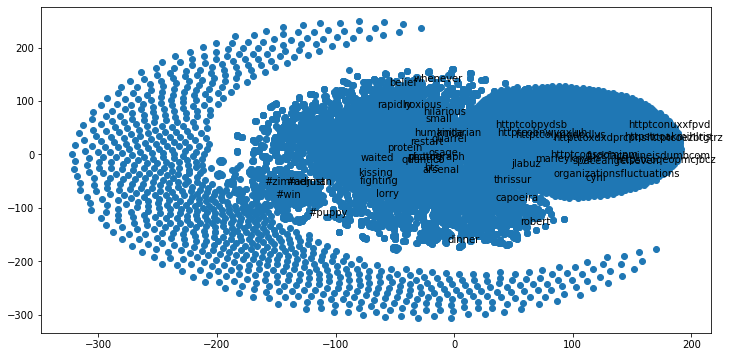

In [70]:
from sklearn.manifold import TSNE

unique_words = list(set([word for sublist in [doc.split() for doc in train['text']] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
tsne = TSNE(n_components=2, n_iter=5000, perplexity=3)

T = tsne.fit_transform(word_glove_vectors)

plt.figure(figsize=(12,6))
plt.scatter(T[:,0], T[:,1])
count = 0
for label, x, y in zip(unique_words, T[:, 0], T[:,1]):
    if count % 500 == 0:
        plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')
    count += 1

In [84]:
from sklearn.cluster import KMeans
from collections import Counter

km = KMeans(n_clusters=3)
km.fit(word_glove_vectors)

KMeans(n_clusters=3)

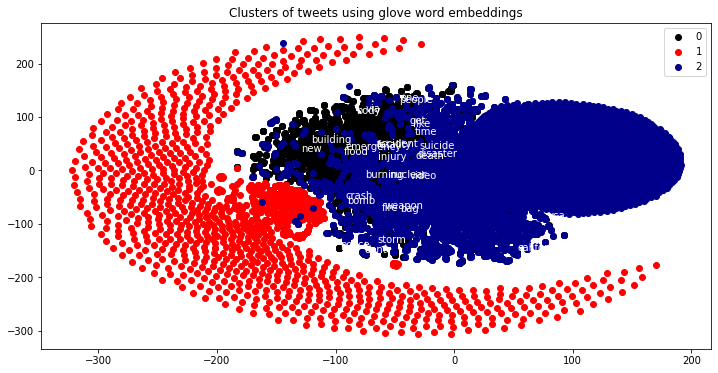

In [95]:
plt.figure(figsize=(12,6))
colors = np.array(['black', 'red', 'darkblue'])
for cluster in range(0, 3):
    t = T[km.labels_ == cluster]
    plt.scatter(t[:,0], t[:,1], c=colors[cluster], label=cluster)
plt.legend()
plt.title('Clusters of tweets using glove word embeddings')

word_counts = Counter([word for sublist in [doc.split() for doc in train['text']] for word in sublist])
most_common_words = [word[0] for word in word_counts.most_common(30)]

for label, x, y in zip(unique_words, T[:, 0], T[:,1]):
    if label in most_common_words:
        plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points', color='white')

In [138]:
unique_words = np.array(unique_words)

# Cluster 0 common words
[(k, v) for k, v in word_counts.most_common(200) if k in unique_words[km.labels_ == 0]][:20]

[('fire', 562),
 ('new', 437),
 ('like', 350),
 ('emergency', 301),
 ('body', 258),
 ('get', 257),
 ('disaster', 255),
 ('building', 247),
 ('via', 229),
 ('storm', 229),
 ('burning', 226),
 ('suicide', 216),
 ('one', 207),
 ('people', 200),
 ('death', 190),
 ('time', 178),
 ('police', 177),
 ('flood', 177),
 ('video', 171),
 ('weapon', 166)]

In [139]:
# Cluster 1 common words
[(k, v) for k, v in word_counts.most_common(2000) if k in unique_words[km.labels_ == 1]][:20]

[('#news', 76),
 ('#hot', 31),
 ('#prebreak', 30),
 ('#best', 30),
 ('#hiroshima', 24),
 ('#nowplaying', 23),
 ('#islam', 23),
 ('#earthquake', 19),
 ('#gbbo', 19),
 ('#jobs', 14),
 ('#job', 12),
 ('#isis', 12),
 ('#breaking', 11),
 ('#world', 11),
 ('#japan', 11),
 ('#hiring', 11),
 ('#terrorism', 11),
 ('#rt', 10),
 ('#india', 10),
 ('#bbc', 10)]

In [140]:
# Cluster 3 common words
[(k, v) for k, v in word_counts.most_common(2000) if k in unique_words[km.labels_ == 2]][:20]

[('usa', 274),
 ('california', 199),
 ('dont', 195),
 ('bomb', 188),
 ('bag', 159),
 ('crash', 156),
 ('york', 155),
 ('london', 132),
 ('casualty', 130),
 ('dead', 127),
 ('siren', 123),
 ('got', 117),
 ('man', 112),
 ('fatal', 103),
 ('cant', 102),
 ('let', 101),
 ('youtube', 97),
 ('wreck', 97),
 ('canada', 96),
 ('flame', 96)]